In [8]:
class Regresor:
    def __init__(self) -> None:
        self.coeficienti = []
    
    def produsMatrici(self, matrice1, matrice2):
        produs = []
        for i in range(0, len(matrice1)):
            produs.append([])
            for j in range(0, len(matrice2[-1])):
                produs[-1].append(sum([matrice1[i][k] * matrice2[k][j] for k in range(0, len(matrice1[-1]))]))
        return produs

    def eliminaLiniaXsiColoanaY(self, matrice, i, j):
        matriceNoua = []
        for linie in range(0, len(matrice)):
            if linie != i:
                matriceNoua.append([matrice[linie][col] for col in range(0, len(matrice[-1])) if col != j])
        return matriceNoua

    def determinantMatrice(self, matrice):
        if len(matrice) == 1 and len(matrice[-1]) == 1:
            return matrice[0][0]
        return sum([(-1)**k * self.determinantMatrice(self.eliminaLiniaXsiColoanaY(matrice, 0, k)) * matrice[0][k] for k in range(0, len(matrice[-1]))]) 

    def transpusaMatrice(self, matrice):
        transpusa = []
        for j in range(0, len(matrice[-1])):
            transpusa.append([matrice[k][j] for k in range(0, len(matrice))])
        return transpusa

    def matriceAdjuncta(self, matrice):
        adjuncta = []
        for i in range(0, len(matrice)):
            adjuncta.append([])
            for j in range(0, len(matrice[-1])):
                adjuncta[-1].append((-1)**(i+j) * self.determinantMatrice(self.eliminaLiniaXsiColoanaY(matrice, i, j)))
        return adjuncta

    def inmultireMatriceCuUnCoeficient(self, matrice, numar):
        matriceNoua = []
        for i in range(0, len(matrice)):
            matriceNoua.append([])
            for j in range(0, len(matrice[-1])):
                matriceNoua[-1].append(numar * matrice[i][j])
        return matriceNoua

    def inversaMatrice(self, matrice):
        determinant = self.determinantMatrice(matrice)
        adjuncta = self.matriceAdjuncta(matrice)
        inversa = self.inmultireMatriceCuUnCoeficient(adjuncta, 1/determinant)
        return inversa

    def train(self,input, output):
        matrice = [[1] + linie for linie in input]
        #inversa(transpusa * matrice) * transpusa * output
        transpusa = self.transpusaMatrice(matrice)
        produs1 = self.produsMatrici(transpusa, matrice)
        inversa = self.inversaMatrice(produs1)
        produs2 = self.produsMatrici(inversa, transpusa)
        matriceRezultat = self.produsMatrici(produs2, [[output[k]] for k in range(0, len(output))])
        self.coeficienti = matriceRezultat

    def returneazaCoeficienti(self):
        return self.coeficienti

    def prediction(self,input):
        """
        Pentru o lista de input-uri se va return o lista de output-uri
        """
        matrice = [[1] + linie for linie in input]
        output = []
        for i in range(0, len(matrice)):
            output.append(sum([self.coeficienti[k][-1] * matrice[i][k] for k in range(0, len(matrice[-1]))]))
        return output



In [9]:
#pt v1 a

import csv
import os
import matplotlib.pyplot as plt
import numpy as np 
from sklearn import linear_model
import pandas as pd 
from sklearn.metrics import mean_squared_error

def readData(dataPath: str):
    df = pd.read_csv(dataPath, delimiter=',', header='infer')
    df = df.dropna()
    return df


def plotDataDistribution(dfWorldHappiness):
    fig, axes = plt.subplots(nrows=2, figsize=(15,15))
    axes[0].hist(dfWorldHappiness["Happiness.Score"])
    axes[0].set_title("Happiness")
    axes[1].hist(dfWorldHappiness["Economy..GDP.per.Capita."])
    axes[1].set_title("PIB")
    plt.show()

def plotData(dfWorldHappiness):
    fig, axes = plt.subplots()
    axes.plot(dfWorldHappiness["Economy..GDP.per.Capita."], dfWorldHappiness["Happiness.Score"], 'ro')
    axes.set_xlabel('GDP')
    axes.set_ylabel('Happiness')
    axes.set_title('Relation between GDP and Happiness')
    plt.show()

def getTrainingAndValidationSets(dfWorldHappiness):
    dataSize = dfWorldHappiness.shape[0]
    
    trainingIndexSet = np.random.choice(range(dataSize), size=int(0.8 * dataSize), replace=False)
    validationIndexSet = [i for i in range(dataSize) if i not in trainingIndexSet]

    trainingInputSet = [dfWorldHappiness["Economy..GDP.per.Capita."].iloc[index] for index in trainingIndexSet]
    trainingOutputSet = [dfWorldHappiness["Happiness.Score"].iloc[index] for index in trainingIndexSet]

    validationInputSet = [dfWorldHappiness["Economy..GDP.per.Capita."].iloc[index] for index in validationIndexSet]
    validationOutputSet = [dfWorldHappiness["Happiness.Score"].iloc[index] for index in validationIndexSet]

    return trainingInputSet, trainingOutputSet, validationInputSet, validationOutputSet


def plotTrainingAndValidationSets(dfWorldHappiness):
    trainingInputSet, trainingOutputSet, validationInputSet, validationOutputSet = getTrainingAndValidationSets(dfWorldHappiness)
    fig, axes = plt.subplots()

    plt.plot(trainingInputSet, trainingOutputSet, 'ro', label='TRAINING DATA')
    #training data = cercuri rosii

    plt.plot(validationInputSet, validationOutputSet, 'g^', label='VALIDATION DATA')
    #validation data = triunghiuri verzi

    axes.set_title("Training and validation data")
    axes.set_xlabel("GDP")
    axes.set_ylabel("HAPPINESS")
    plt.legend()
    plt.show()

def getRegressor(dfWorldHappiness):
    trainingInputSet, trainingOutputSet, _, _ = getTrainingAndValidationSets(dfWorldHappiness)
    X = [[el] for el in trainingInputSet]
    regressor = Regresor()
    regressor.train([[trainingInputSet[i]] for i in range(0, len(trainingInputSet))], trainingOutputSet)
    return regressor

def plotRegressor(dfWorldHappiness):
    trainingInputSet, trainingOutputSet, _, _ = getTrainingAndValidationSets(dfWorldHappiness)
    regressor = getRegressor(dfWorldHappiness)
    w0, w1 = regressor.coeficienti[0][-1], regressor.coeficienti[1][-1]
    numberOfPoints = 1000
    xref = []
    val = min(trainingInputSet)
    step = (max(trainingInputSet) - min(trainingInputSet)) / numberOfPoints
    for i in range(1, numberOfPoints):
        xref.append(val)
        val += step
    yref = [w0 + w1*el for el in xref]

    fig, axes = plt.subplots()
    axes.plot(trainingInputSet, trainingOutputSet, 'ro', label = 'TRAINING DATA')
    #training data = cercuri rosii

    axes.plot(xref, yref, 'b-', label= 'LEARNED MODEL')
    #linii albastre

    axes.set_title('Training data and learned model')
    axes.set_xlabel('GDP')
    axes.set_ylabel('HAPPINESS')
    axes.legend()
    plt.show()


def getErrors(dfWorldHappiness):
    _,_, validationInputSet, validationOutputSet = getTrainingAndValidationSets(dfWorldHappiness)
    regressor = getRegressor(dfWorldHappiness)
    computedValidationOutputs = regressor.prediction([[x] for x in validationInputSet])
    manualError = 0.0
    for t1, t2 in zip(computedValidationOutputs, validationOutputSet):
        manualError += (t1 - t2)**2
    manualError = manualError / len(validationOutputSet)
    computedError = mean_squared_error(validationOutputSet, computedValidationOutputs)
    return manualError, computedError

In [18]:
#v1 b
import csv
import os
import matplotlib.pyplot as plt
import numpy as np 
from sklearn import linear_model
import pandas as pd 
from sklearn.metrics import mean_squared_error

def readData2(dataPath: str):
    world_happiness = pd.read_csv(dataPath, delimiter=',', header='infer')
    world_happiness["Happiness.Score"] = world_happiness["Happiness.Score"].fillna(world_happiness["Happiness.Score"].mode()[0])
    world_happiness["Economy..GDP.per.Capita."] = world_happiness["Economy..GDP.per.Capita."].fillna(world_happiness["Economy..GDP.per.Capita."].mode()[0])
    world_happiness["Freedom"] = world_happiness["Freedom"].fillna(world_happiness["Freedom"].mode()[0])
    
    q1= world_happiness["Happiness.Score"].quantile(0.01)
    q2= world_happiness["Happiness.Score"].quantile(0.99)

    world_happiness = world_happiness[world_happiness["Happiness.Score"].between(q1,q2)]

    q3= world_happiness["Economy..GDP.per.Capita."].quantile(0.01)
    q4= world_happiness["Economy..GDP.per.Capita."].quantile(0.99)

    world_happiness = world_happiness[world_happiness["Economy..GDP.per.Capita."].between(q3,q4)]

    q5= world_happiness["Freedom"].quantile(0.01)
    q6= world_happiness["Freedom"].quantile(0.99)

    world_happiness = world_happiness[world_happiness["Freedom"].between(q5,q6)]
    return world_happiness


def plotDataDistribution2(dfWorldHappiness):
    fig, axes = plt.subplots(nrows=3, figsize=(15,15))
    axes[0].hist(dfWorldHappiness["Happiness.Score"])
    axes[0].set_title("Happiness")
    axes[1].hist(dfWorldHappiness["Economy..GDP.per.Capita."])
    axes[1].set_title("PIB")
    axes[2].hist(dfWorldHappiness["Freedom"])
    axes[2].set_title("Freedom")
    plt.show()

def plotData2(dfWorldHappiness):
    fig = plt.figure()
    axes = fig.add_subplot(projection='3d')
    axes.scatter(dfWorldHappiness["Economy..GDP.per.Capita."], dfWorldHappiness["Freedom"],dfWorldHappiness["Happiness.Score"], 'ro')
    axes.set_xlabel('GDP')
    axes.set_ylabel('Freedom')
    axes.set_zlabel('Happiness')
    axes.set_title('Relation between GDP, Freedom and Happiness')
    plt.show()

def getTrainingAndValidationSets2(dfWorldHappiness):
    dataSize = dfWorldHappiness.shape[0]
    
    trainingIndexSet = np.random.choice(range(dataSize), size=int(0.8 * dataSize), replace=False)
    validationIndexSet = [i for i in range(dataSize) if i not in trainingIndexSet]

    trainingInputSet = [[dfWorldHappiness["Economy..GDP.per.Capita."].iloc[index], dfWorldHappiness["Freedom"].iloc[index]] for index in trainingIndexSet]
    trainingOutputSet = [dfWorldHappiness["Happiness.Score"].iloc[index] for index in trainingIndexSet]

    validationInputSet = [[dfWorldHappiness["Economy..GDP.per.Capita."].iloc[index], dfWorldHappiness["Freedom"].iloc[index]] for index in validationIndexSet]
    validationOutputSet = [dfWorldHappiness["Happiness.Score"].iloc[index] for index in validationIndexSet]

    return trainingInputSet, trainingOutputSet, validationInputSet, validationOutputSet


def plotTrainingAndValidationSets2(dfWorldHappiness):
    trainingInputSet, trainingOutputSet, validationInputSet, validationOutputSet = getTrainingAndValidationSets2(dfWorldHappiness)
    fig = plt.figure()
    axes = fig.add_subplot(projection='3d')
    xvalue = [pereche[0] for pereche in trainingInputSet] #gdp
    yvalue = [pereche[1] for pereche in trainingInputSet] #freedom
    zvalue = trainingOutputSet #happiness

    xvalueValidation = [pereche[0] for pereche in validationInputSet] #gdp
    yvalueValidation = [pereche[1] for pereche in validationInputSet] #freedom
    zvalueValidation = validationOutputSet #happiness

    axes.scatter(xvalue, yvalue, zvalue, 'ro')
    axes.scatter(xvalueValidation, yvalueValidation, zvalueValidation, 'g^')

    axes.set_xlabel('GDP')
    axes.set_ylabel('Freedom')
    axes.set_zlabel('Happiness')
    axes.set_title('Relation between GDP, Freedom and Happiness')
    plt.show()
    

def getRegressor2(dfWorldHappiness):
    trainingInputSet, trainingOutputSet, _, _ = getTrainingAndValidationSets2(dfWorldHappiness)
    X = [el for el in trainingInputSet]
    regressor = Regresor()
    regressor.train(trainingInputSet, trainingOutputSet)
    return regressor

def plotRegressor2(dfWorldHappiness):
    trainingInputSet, trainingOutputSet, _, _ = getTrainingAndValidationSets2(dfWorldHappiness)
    trainingInputSet = np.array(trainingInputSet)  # Convert to NumPy array
    regressor = getRegressor2(dfWorldHappiness)
    w0, w1, w2 = regressor.coeficienti[0][-1], regressor.coeficienti[1][-1], regressor.coeficienti[2][-1]
    
    # Generate data for plotting the plane
    x_min, x_max = np.min(trainingInputSet[:,0]), np.max(trainingInputSet[:,0])
    y_min, y_max = np.min(trainingInputSet[:,1]), np.max(trainingInputSet[:,1])
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 20), np.linspace(y_min, y_max, 20))
    zz = w0 + w1 * xx + w2 * yy

    # Plot the data points
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(trainingInputSet[:,0], trainingInputSet[:,1], trainingOutputSet, c='b', marker='o', label='Training Data')
    
    # Plot the plane representing the model
    ax.plot_surface(xx, yy, zz, alpha=0.5, cmap='viridis', label='Model Plane')
    
    ax.set_title('Training Data and Model Plane')
    ax.set_xlabel('GDP')
    ax.set_ylabel('Freedom')
    ax.set_zlabel('Happiness')
    
    plt.show()

def getErrors2(dfWorldHappiness):
    _,_, validationInputSet, validationOutputSet = getTrainingAndValidationSets2(dfWorldHappiness)
    regressor = getRegressor2(dfWorldHappiness)
    computedValidationOutputs = regressor.prediction(validationInputSet)
    manualError = 0.0
    for t1, t2 in zip(computedValidationOutputs, validationOutputSet):
        manualError += (t1 - t2)**2
    manualError = manualError / len(validationOutputSet)
    computedError = mean_squared_error(validationOutputSet, computedValidationOutputs)
    return manualError, computedError


## PROBLEMA V1 - PIB

<h2>Distributia datelor</h2>

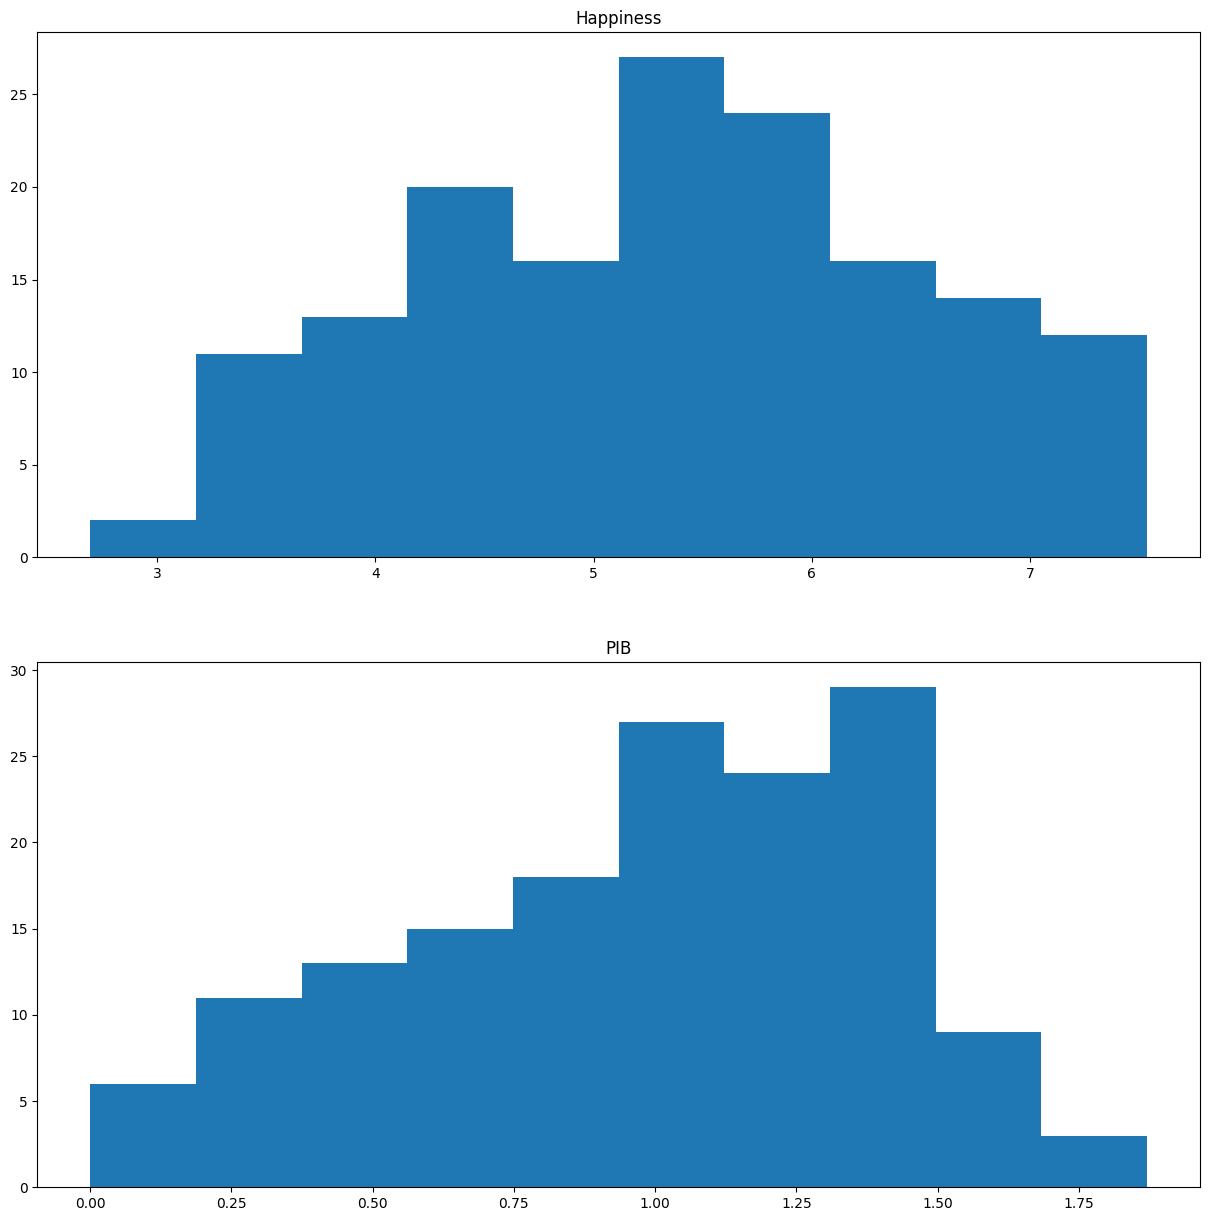

In [19]:
worldHappiness = readData("v1_world-happiness-report-2017.csv");
plotDataDistribution(worldHappiness)

<h2>Plot Data</h2>

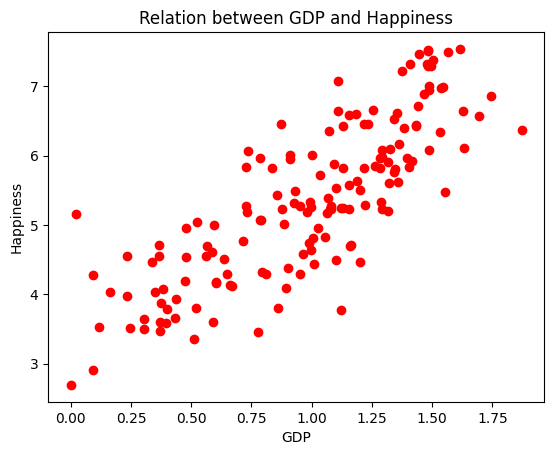

In [20]:
plotData(worldHappiness)

<h2>Impartirea datelor in date de antrenament si date de test</h2>

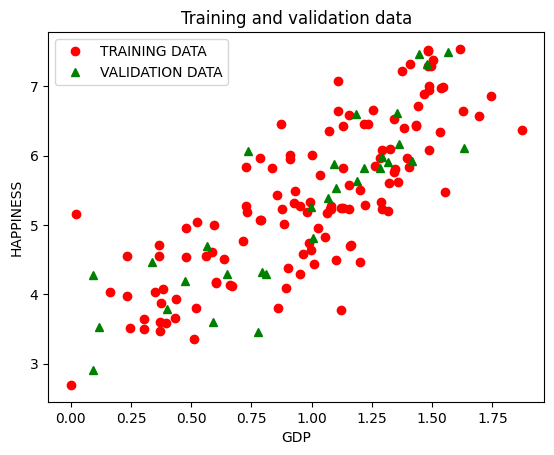

In [21]:
plotTrainingAndValidationSets(worldHappiness)

<h2>Regresor</h2>

LEARNED MODEL: f(x) =  3.213780820865845  +  2.229295872157223  * x
MANUAL ERROR =  0.39067462828617405
COMPUTED ERROR =  0.39067462828617394


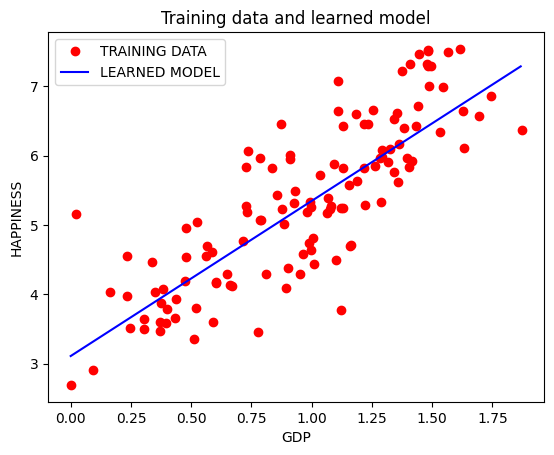

In [22]:
regressor = getRegressor(worldHappiness)
w0, w1 = regressor.coeficienti[0][-1], regressor.coeficienti[1][-1]
print("LEARNED MODEL: f(x) = ", w0, " + ", w1, " * x")

manualError, computedError = getErrors(worldHappiness)
print("MANUAL ERROR = ", manualError)
print("COMPUTED ERROR = ", computedError)
plotRegressor(worldHappiness)

## PROBLEMA V1 - PIB si Freedom

<h2>Distributia datelor</h2>

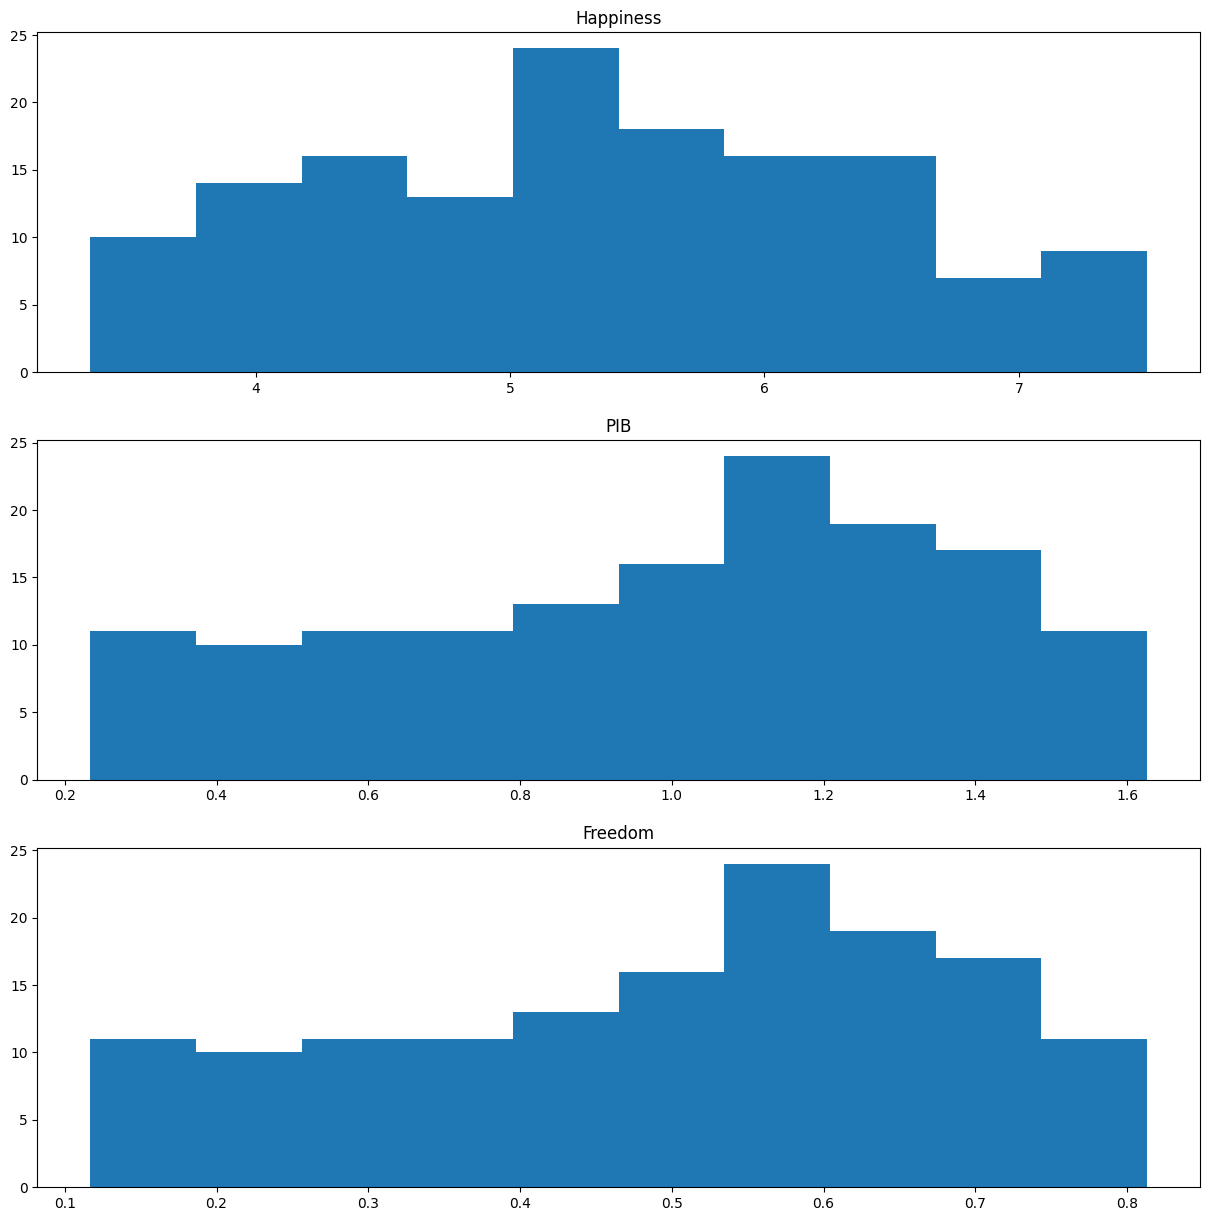

In [23]:
worldHappiness2 = readData2("v2_world-happiness-report-2017.csv");
plotDataDistribution2(worldHappiness2)

<h2>Plot data</h2>

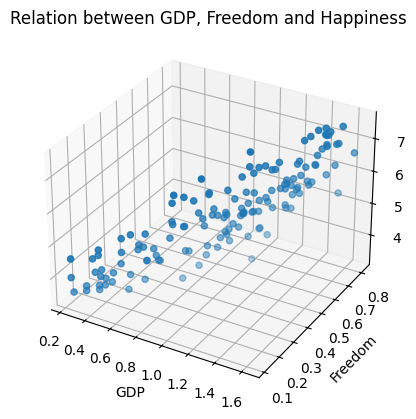

In [24]:
plotData2(worldHappiness2)

<h2>Impartirea datelor in date de antrenament si date de test</h2>

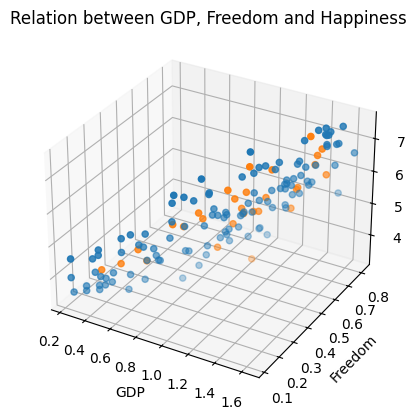

In [25]:
plotTrainingAndValidationSets2(worldHappiness2)

<h2>Regresor</h2>

In [28]:
regressor2 = getRegressor2(worldHappiness2)
w0, w1, w2 = regressor2.coeficienti[0][-1], regressor2.coeficienti[1][-1], regressor2[2][-1]
print("LEARNED MODEL: f(x) = ", w0, " + ", w1, " * x1", " + ", w2, " * x2")

manualError, computedError = getErrors2(worldHappiness2)
print("MANUAL ERROR = ", manualError)
print("COMPUTED ERROR = ", computedError)
plotRegressor(worldHappiness2)

TypeError: 'Regresor' object is not subscriptable